In [1]:
import pandas as pd
import numpy as np
import math as math
import random
from sklearn.utils import shuffle
import sklearn.preprocessing  as prepro
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import shap
import gradio
from xgboost import XGBClassifier
# from adjustText import adjust_text


#constants
random_state = 42
plotColor = ['b','g','r','m','c', 'y']
markers = ['+','o','*','^','v','>','<']

#set up
sns.set(style='whitegrid')
%matplotlib inline

In [2]:
data = pd.read_csv("orange_data_preprocessed.csv")
data = data.drop(columns="Unnamed: 0")
data

,Account length,International plan,Voice mail plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Churn
0,128,0,1,25,45.07,16.78,11.01,2.70,1,0
1,107,0,1,26,27.47,16.62,11.45,3.70,1,0
2,137,0,0,0,41.38,10.30,7.32,3.29,0,0
3,84,1,0,0,50.90,5.26,8.86,1.78,2,0
4,75,1,0,0,28.34,12.61,8.41,2.73,3,0
...,...,...,...,...,...,...,...,...,...,...
3199,192,0,1,36,26.55,18.32,12.56,2.67,2,0
3200,68,0,0,0,39.29,13.04,8.61,2.59,3,0
3201,28,0,0,0,30.74,24.55,8.64,3.81,2,0
3202,184,1,0,0,36.35,13.57,6.26,1.35,2,0


In [3]:
X = data.drop(columns="Churn")
y = data["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print("----------------------------")
print("Original features shape, ", X.shape)
print("Original target shape, ", y.shape)
print("x train shape, ", X_train.shape)
print("y train shape, ", y_train.shape)
print("x test shape, ", X_test.shape)
print("y test shape, ", y_test.shape)
print("----------------------------")

----------------------------
Original features shape,  (3204, 9)
Original target shape,  (3204,)
x train shape,  (2563, 9)
y train shape,  (2563,)
x test shape,  (641, 9)
y test shape,  (641,)
----------------------------


In [4]:
smote = SMOTE(random_state=42)
X_train_upsampled , y_train_upsampled = smote.fit_resample(X_train,y_train)
print("----------------------------")
print("Original x train shape, ", X_train.shape)
print("Resample x train shape, ", X_train_upsampled.shape)
print("----------------------------")

----------------------------
Original x train shape,  (2563, 9)
Resample x train shape,  (4390, 9)
----------------------------


In [5]:
from imblearn.under_sampling import RandomUnderSampler

# Define the undersampler
rus = RandomUnderSampler(random_state=random_state)

# Fit and resample the training data
x_train_downsampled, y_train_downsampled = rus.fit_resample(X_train, y_train)

# Print shapes to compare
print("----------------------------")
print("Original x_train shape: ", X_train.shape)
print("Downsampled x_train shape: ", x_train_downsampled.shape)
print("----------------------------")


----------------------------
Original x_train shape:  (2563, 9)
Downsampled x_train shape:  (736, 9)
----------------------------


Choosing XGBoost, the upsampled versino

In [6]:
import yaml

# Load the YAML file
with open('../../model_artifact/training/orange/oversampling.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Get the list of models
models = config["models"]

# Extract hyperparameters for each model
os_xgboost_params = next(model['hyperparameters'] for model in models if model['name'] == 'XGBoost')
os_xgboost_threshold = 0.518781
# Print the hyperparameters for each model
print("XGBoost Parameters:", os_xgboost_params)
print(f"XGBoost Threshold: {os_xgboost_threshold} ")

# Build model and evaluate
xai_model = XGBClassifier(**os_xgboost_params)
trained_xai_model = xai_model.fit(X_train_upsampled, y_train_upsampled)

XGBoost Parameters: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 1}
XGBoost Threshold: 0.518781 


In [7]:
import shap
shap.initjs()

In [8]:
# For correct set
# explainer = shap.TreeExplainer(model=trained_xai_model,data=X_train_upsampled,model_output="probability")

In [9]:
# explainer_ndarray = explainer.shap_values(X_test)
# explainer_object = explainer(X_test)

In [10]:
import pickle

# Save the explainer object using pickle
#with open("../../model_artifact/training/orange/orange_explainer.pkl", "wb") as f:
#    pickle.dump(explainer_object, f)


In [11]:
import pickle
# Load the explainer object using pickle
with open("../../model_artifact/training/orange/orange_explainer.pkl", "rb") as f:
    explainer_object = pickle.load(f)

In [12]:
# Cach cai cua XGBoost khac voi random forest nen la base value chi co v thoi
explainer_object

.values =
array([[-0.11230296, -0.00772701, -0.1451279 , ...,  0.00990938,
        -0.01930889, -0.03439836],
       [ 0.07336911,  0.00444761, -0.0627726 , ...,  0.00742122,
         0.03462214, -0.01153935],
       [ 0.01703815, -0.00095359,  0.00289711, ...,  0.03438185,
         0.0119825 ,  0.23589909],
       ...,
       [-0.08680175, -0.0108391 ,  0.05341358, ...,  0.06187312,
         0.07247257, -0.01015336],
       [-0.07671933, -0.00851543, -0.10424908, ..., -0.14584237,
        -0.00999328, -0.00735105],
       [-0.05034297, -0.04067851,  0.0075945 , ...,  0.00916903,
         0.13144258, -0.05987956]])

.base_values =
array([0.46316276, 0.46316276, 0.46316276, 0.46316276, 0.46316276,
       0.46316276, 0.46316276, 0.46316276, 0.46316276, 0.46316276,
       0.46316276, 0.46316276, 0.46316276, 0.46316276, 0.46316276,
       0.46316276, 0.46316276, 0.46316276, 0.46316276, 0.46316276,
       0.46316276, 0.46316276, 0.46316276, 0.46316276, 0.46316276,
       0.46316276, 0.46316

# Local Interpret

In [13]:
X_test

,Account length,International plan,Voice mail plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls
610,13,0,1,31,45.10,12.55,11.67,3.48,1
3047,91,0,1,44,36.82,14.71,10.89,2.46,1
2724,89,0,0,0,21.96,18.20,9.67,2.78,5
1913,84,0,0,0,28.82,13.40,4.42,2.86,0
2882,113,0,1,34,7.63,11.41,7.58,3.59,1
...,...,...,...,...,...,...,...,...,...
2229,43,0,1,35,34.03,20.77,9.32,3.13,3
1025,158,0,0,0,35.68,18.81,9.45,2.21,1
1029,111,0,0,0,43.50,17.35,7.71,3.32,3
1926,86,0,1,33,43.03,17.86,4.27,3.21,3


The prediction for XGBoost is for the class 1, contract with Random Forest

Label for instance 89: 0


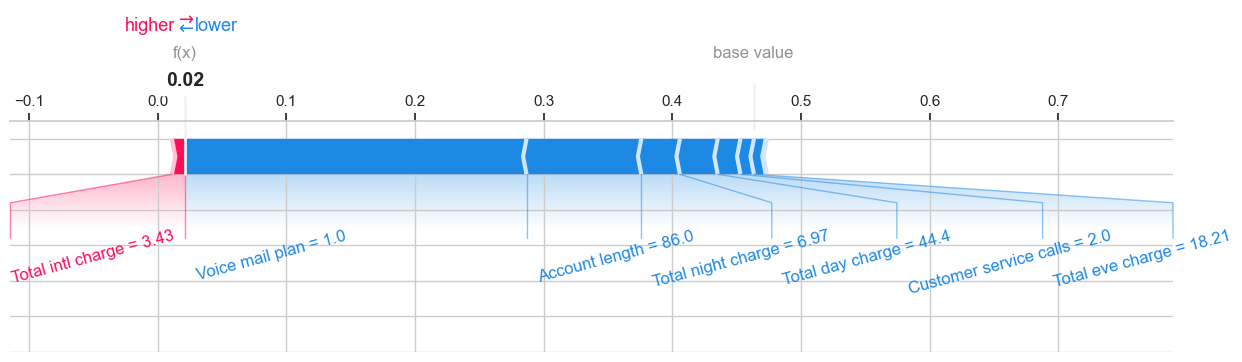

Label for instance 122: 0


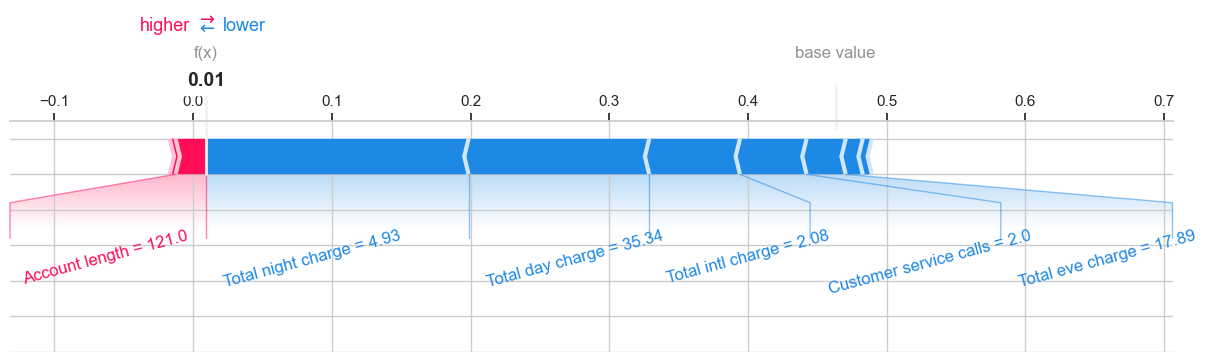

Label for instance 345: 0


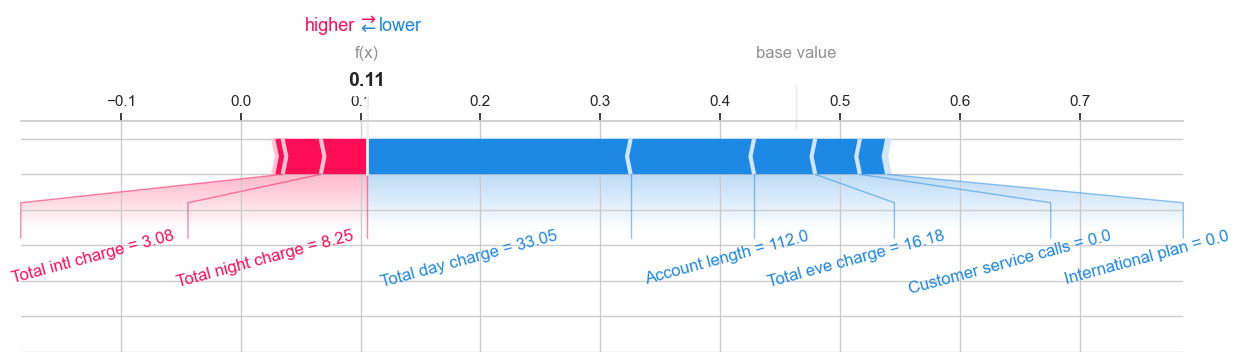

Label for instance 98: 0


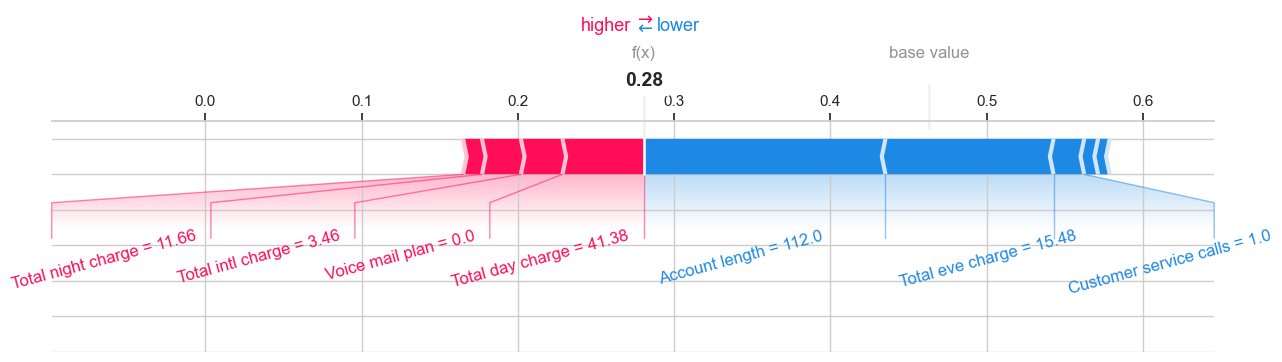

Label for instance 4: 0


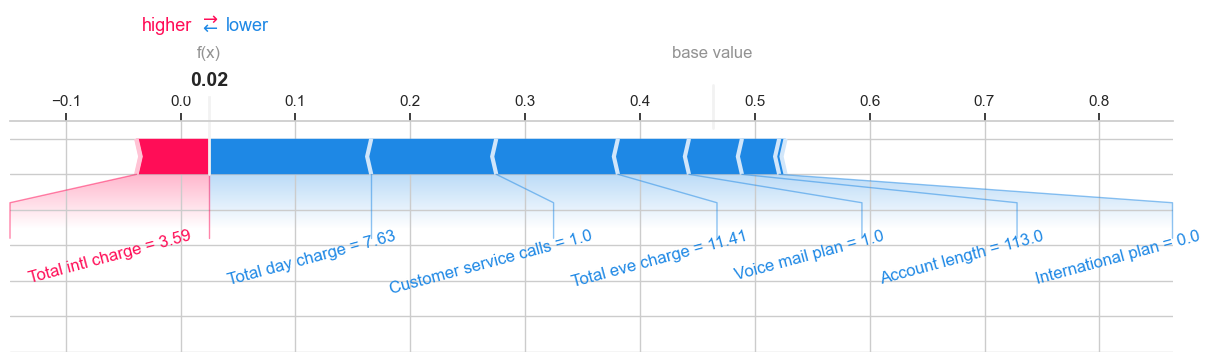

In [14]:
idx = [89, 122, 345, 98, 4]
for i in [89, 122, 345, 98, 4]:
    # Randomly sample an index from X_test

    # Get the corresponding instance and label
    instance = X_test.iloc[i:i+1]  # Single instance
    label = y_test.iloc[i]  # Corresponding label
    
    # Print out the label
    print(f"Label for instance {i}: {label}")
    
    # Generate SHAP values for the instance
    #shap_values = explainer(instance)
    
    # Plot the SHAP force plot for the sampled instance
    shap.force_plot(explainer_object.base_values[0], explainer_object.values[i,:], instance, matplotlib=True,text_rotation=15, figsize=(15,3))
    
    # Show the plot
    plt.show()

In [15]:
indices_list=[89, 122, 345, 98, 4]
# Get the corresponding instances from X_test
instances = X_test.iloc[indices_list]

# Get the predicted probabilities for these instances
predicted_probabilities = trained_xai_model.predict_proba(instances)

# Print out the predicted probabilities for each instance
for idx, prob in zip(indices_list, predicted_probabilities):
    print(f"Instance {idx} - Predicted probability for class 1: {prob[1]}")
    
    # Check if the probability is approximately 0.4459
    if abs(prob[1] - 0.4459) < 0.01:  # A small tolerance to check closeness
        print(f"Instance {idx} has a predicted probability close to 0.4459")


Instance 89 - Predicted probability for class 1: 0.021343505010008812
Instance 122 - Predicted probability for class 1: 0.009250691160559654
Instance 345 - Predicted probability for class 1: 0.10545573383569717
Instance 98 - Predicted probability for class 1: 0.28052079677581787
Instance 4 - Predicted probability for class 1: 0.024854842573404312


In [16]:
shap.force_plot(base_value=explainer_object.base_values[0], 
                shap_values=explainer_object.values[:,:],
                features=X_test)

# Global interpret

In [17]:
feature_names = X_test.columns.to_list()
feature_names

['Account length',
 'International plan',
 'Voice mail plan',
 'Number vmail messages',
 'Total day charge',
 'Total eve charge',
 'Total night charge',
 'Total intl charge',
 'Customer service calls']

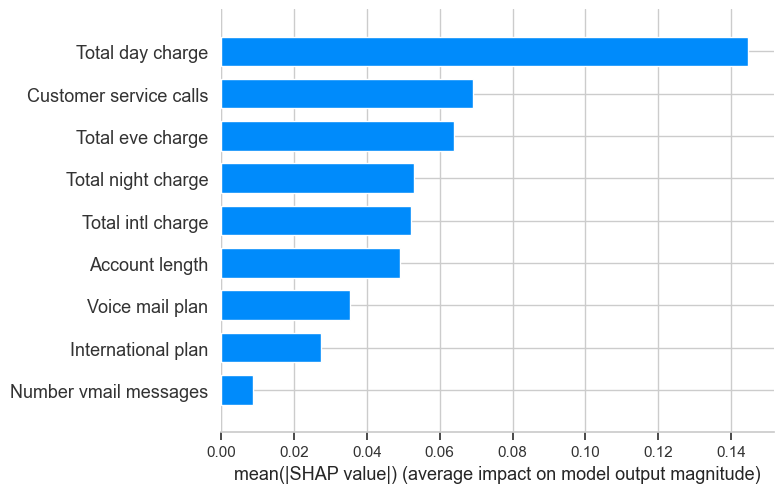

In [18]:
shap.summary_plot(shap_values=explainer_object.values[:,:],
                  features = X_test,
                  feature_names = feature_names,
                  max_display = 15,
                  plot_type = "bar")

c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\plots\_violin.py:271: UserWarning: not enough data in bin #8 for feature Customer service calls, so it'll be ignored. Try increasing the number of records to plot.
  warnings.warn(


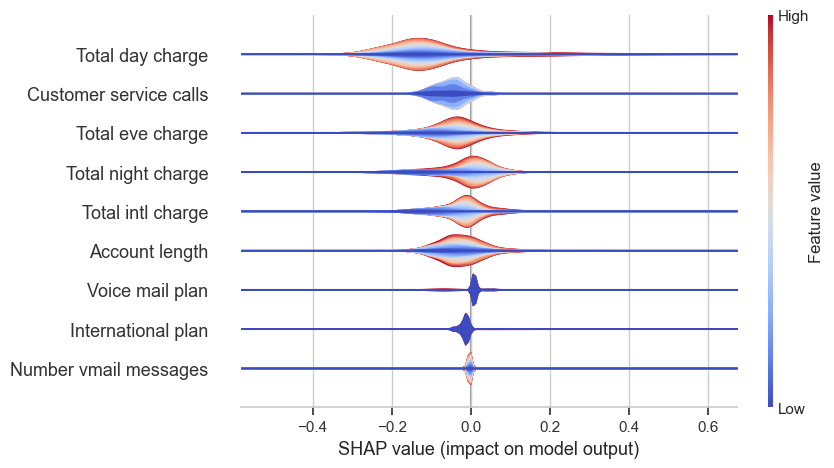

In [19]:
shap.plots.violin(shap_values=explainer_object.values[:,:], features=X_test, plot_type="layered_violin",max_display = 10)

In [20]:
explainer_object.feature_names

['Account length',
 'International plan',
 'Voice mail plan',
 'Number vmail messages',
 'Total day charge',
 'Total eve charge',
 'Total night charge',
 'Total intl charge',
 'Customer service calls']

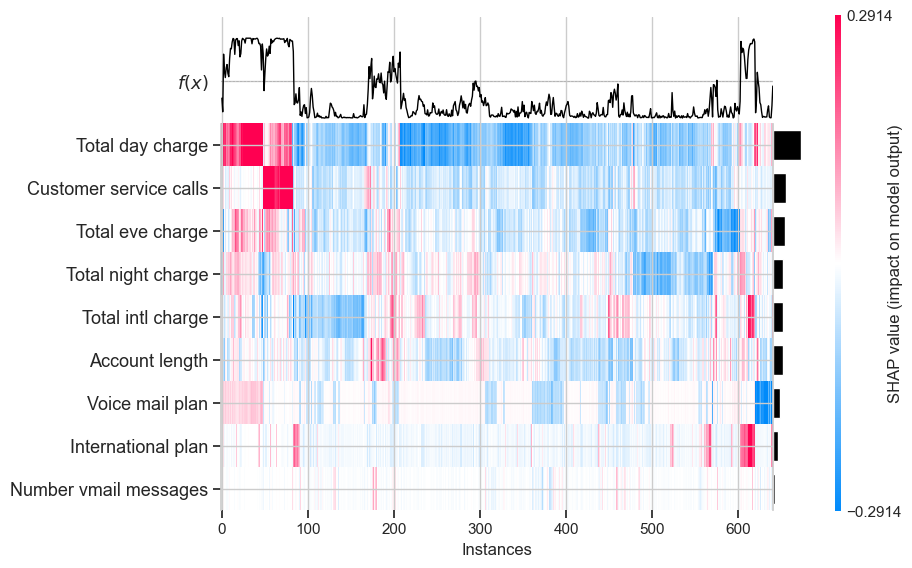

<Axes: xlabel='Instances'>

In [21]:
shap.plots.heatmap(shap_values=explainer_object[:,:], max_display=10)

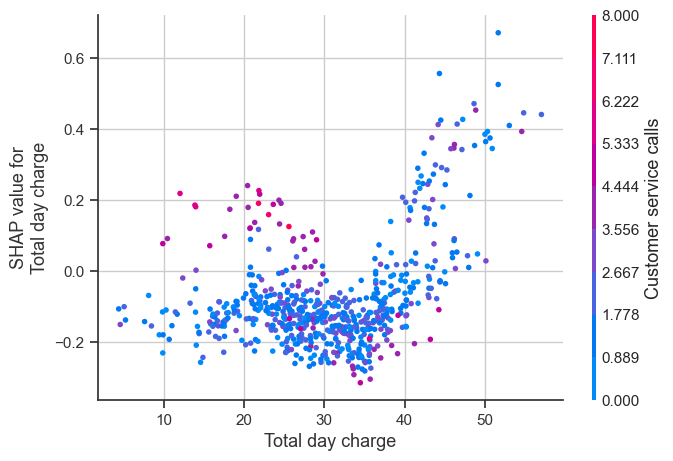

In [22]:
shap.dependence_plot(ind="Total day charge", shap_values=explainer_object.values,
                     features=X_test, feature_names=feature_names)

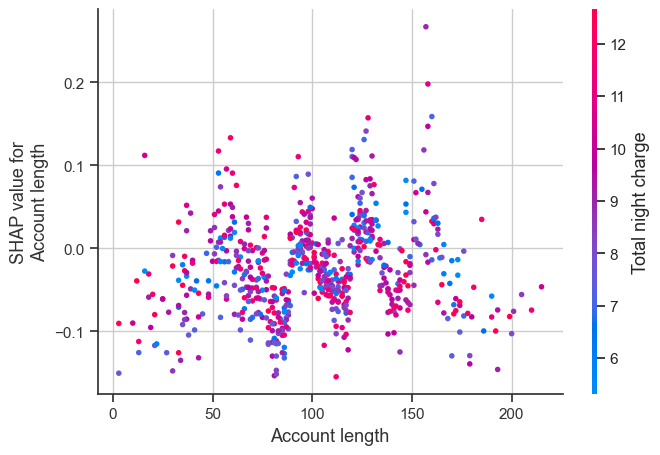

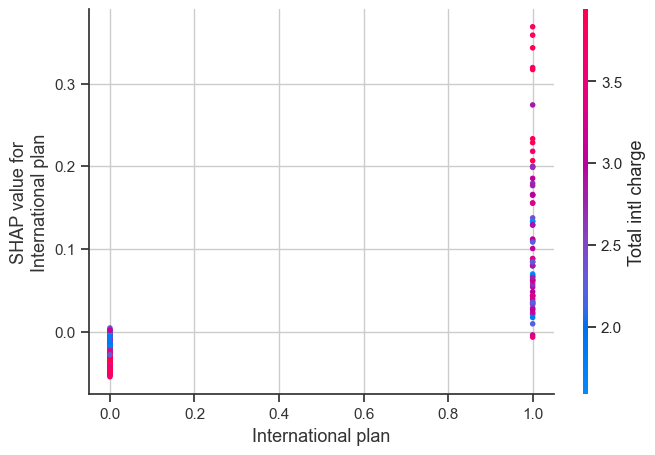

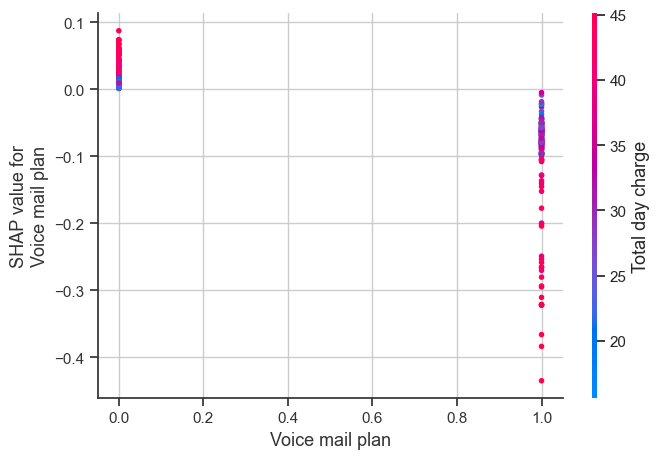

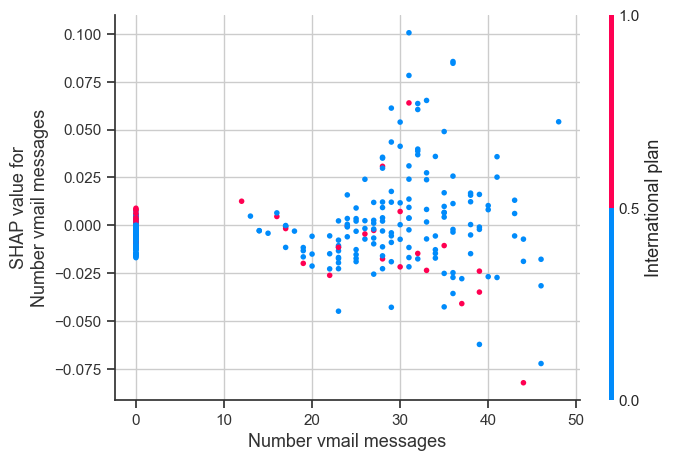

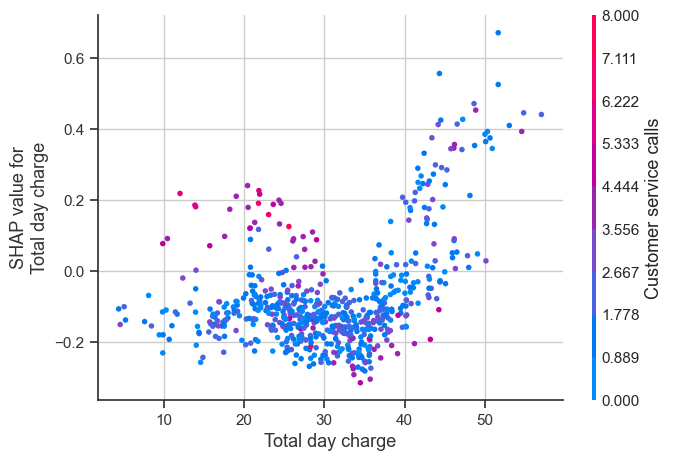

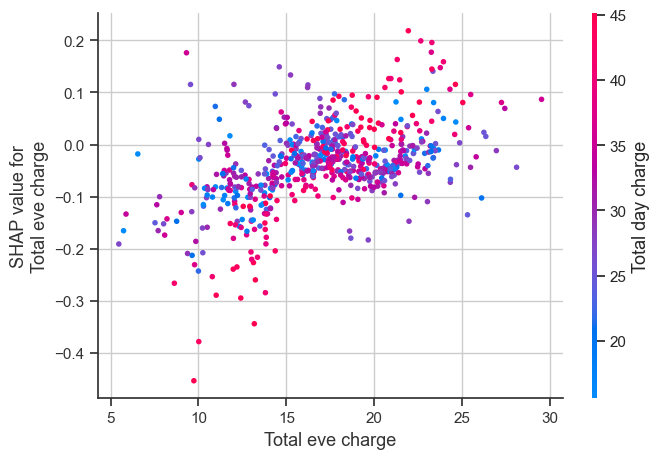

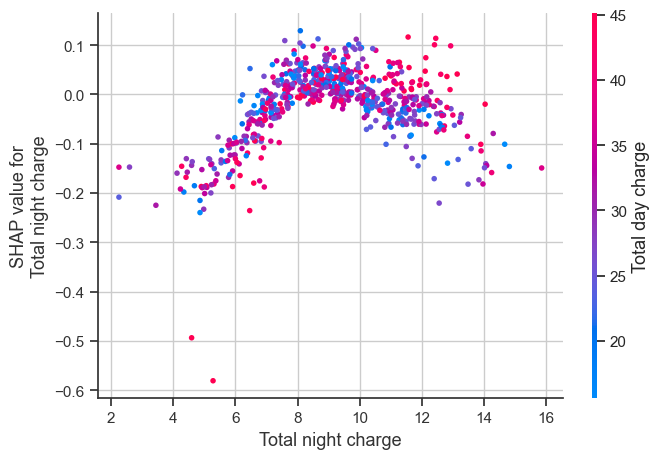

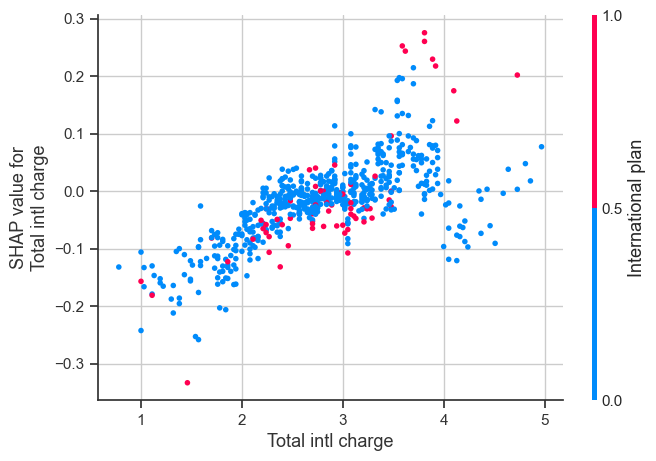

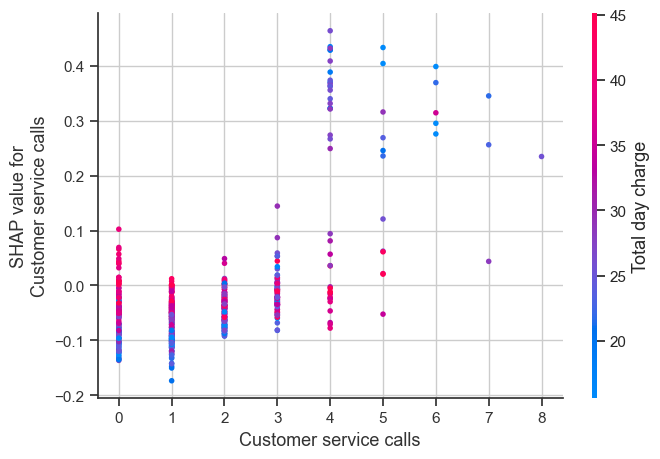

In [23]:
for i in feature_names:
    shap.dependence_plot(ind=i, shap_values=explainer_object.values,
                     features=X_test, feature_names=feature_names)

<Axes: >

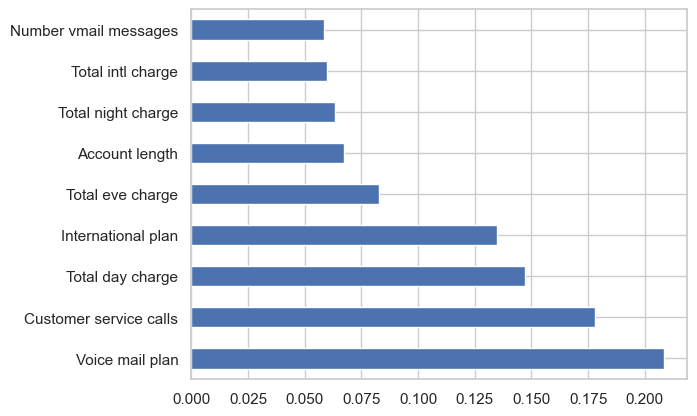

In [25]:
feat_importances = pd.Series(trained_xai_model.feature_importances_, index=X_train_upsampled.columns)
feat_importances.nlargest(20).plot(kind='barh')